Saving image.png to image (2).png


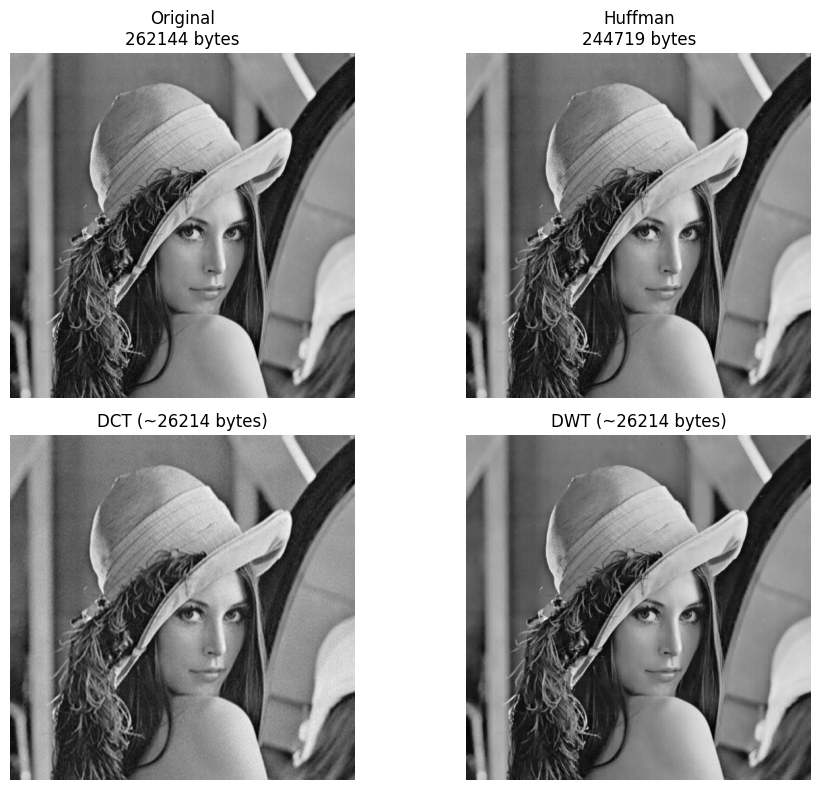

In [5]:


import heapq
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pywt
from scipy.fftpack import dct, idct
from google.colab import files


# ----------- Minimal Upload (As You Requested) -----------
uploaded = files.upload()
img_path = list(uploaded.keys())[0]      # get uploaded filename
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# ---------------- Huffman Compression ----------------
def huffman_compress_decompress(img):
    flat = img.flatten().astype(np.uint8)
    freq = Counter(flat)
    heap = []
    counter = 0
    for symbol, f in freq.items():
        node = {"symbol": symbol, "left": None, "right": None}
        heapq.heappush(heap, (f, counter, node))
        counter += 1

    if len(heap) == 1:
        root = heap[0][2]
    else:
        while len(heap) > 1:
            f1, _, n1 = heapq.heappop(heap)
            f2, _, n2 = heapq.heappop(heap)
            parent = {"symbol": None, "left": n1, "right": n2}
            heapq.heappush(heap, (f1 + f2, counter, parent))
            counter += 1
        root = heap[0][2]

    codes = {}
    def build_codes(node, prefix):
        if node["symbol"] is not None:
            codes[node["symbol"]] = prefix or "0"
            return
        build_codes(node["left"], prefix + "0")
        build_codes(node["right"], prefix + "1")
    build_codes(root, "")

    bitstring = "".join(codes[val] for val in flat)
    pad_len = (8 - len(bitstring) % 8) % 8
    bitstring_padded = bitstring + "0" * pad_len
    bits = np.fromiter((int(b) for b in bitstring_padded), dtype=np.uint8)
    encoded_bytes = np.packbits(bits)

    rev_codes = {v: k for k, v in codes.items()}
    bits_dec = np.unpackbits(encoded_bytes).astype(str)
    bitstring_all = "".join(bits_dec)
    if pad_len:
        bitstring_all = bitstring_all[:-pad_len]
    decoded_vals = []
    cur = ""
    for b in bitstring_all:
        cur += b
        if cur in rev_codes:
            decoded_vals.append(rev_codes[cur])
            cur = ""
    decoded = np.array(decoded_vals, dtype=np.uint8).reshape(img.shape)
    return decoded, encoded_bytes

# ---------------- DCT Compression ----------------
def dct2(block):
    return dct(dct(block.T, norm="ortho").T, norm="ortho")

def idct2(block):
    return idct(idct(block.T, norm="ortho").T, norm="ortho")


def dct_compress_decompress(img, keep_ratio=0.1):
    f = img.astype(np.float32)
    C = dct2(f)
    flat = C.flatten()
    k = max(1, int(len(flat) * keep_ratio))
    thresh = np.partition(np.abs(flat), -k)[-k]
    mask = np.abs(C) >= thresh
    C_comp = C * mask
    rec = idct2(C_comp)
    rec = np.clip(rec, 0, 255).astype(np.uint8)
    orig_bits = img.size * 8
    eff_bits = int(orig_bits * keep_ratio)
    effective_sz = eff_bits // 8
    return rec, effective_sz



# ---------------- DWT Compression ----------------
def dwt_compress_decompress(img, wavelet="haar", level=2, keep_ratio=0.1):
    f = img.astype(np.float32)
    coeffs = pywt.wavedec2(f, wavelet=wavelet, level=level)
    all_coeffs = []
    for c in coeffs[1:]:
        for band in c:
            all_coeffs.append(band.flatten())
    if not all_coeffs:
        coeffs_thr = coeffs
    else:
        all_concat = np.concatenate(all_coeffs)
        k = max(1, int(len(all_concat) * keep_ratio))
        thresh = np.partition(np.abs(all_concat), -k)[-k]
        coeffs_thr = [coeffs[0]]
        for c in coeffs[1:]:
            cH, cV, cD = c
            cH_t = pywt.threshold(cH, thresh, mode="hard")
            cV_t = pywt.threshold(cV, thresh, mode="hard")
            cD_t = pywt.threshold(cD, thresh, mode="hard")
            coeffs_thr.append((cH_t, cV_t, cD_t))
    rec = pywt.waverec2(coeffs_thr, wavelet=wavelet)
    rec = rec[:img.shape[0], :img.shape[1]]
    rec = np.clip(rec, 0, 255).astype(np.uint8)
    orig_bits = img.size * 8
    eff_bits = int(orig_bits * keep_ratio)
    effective_sz = eff_bits // 8
    return rec, effective_sz

# ---------------- Run and Display ----------------
orig_size = img.nbytes
img_huff, huff_encoded = huffman_compress_decompress(img)
huff_size = huff_encoded.nbytes
img_dct, dct_size = dct_compress_decompress(img, keep_ratio=0.1)
img_dwt, dwt_size = dwt_compress_decompress(img, keep_ratio=0.1)

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(img, cmap="gray")
plt.title(f"Original\n{orig_size} bytes")
plt.axis("off")


plt.subplot(2,2,2)
plt.imshow(img_huff, cmap="gray")
plt.title(f"Huffman\n{huff_size} bytes")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(img_dct, cmap="gray")
plt.title(f"DCT (~{dct_size} bytes)")
plt.axis("off")
plt.subplot(2,2,4)
plt.imshow(img_dwt, cmap="gray"); plt.title(f"DWT (~{dwt_size} bytes)")
plt.axis("off")

plt.tight_layout()
plt.show()
